In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values.astype('float64')  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values.astype('float64')
    train_ua = train['ua'][:, :12].values.astype('float64')
    train_va = train['va'][:, :12].values.astype('float64')
    train_label = label['nino'][:, 12:36].values.astype('float64')

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
#     data_list = [train_sst,train_t300,train_ua,train_va]
#     train_sst,train_t300,train_ua,train_va = fit_data(data_list, fit=True)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values.astype('float64')  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values.astype('float64')
    train_ua2 = train2['ua'][:, :12].values.astype('float64')
    train_va2 = train2['va'][:, :12].values.astype('float64')
    train_label2 = label2['nino'][:, 12:36].values.astype('float64')
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
#     data_list = [train_sst2,train_t3002,train_ua2,train_va2]
#     train_sst2,train_t3002,train_ua2,train_va2 = fit_data(data_list, fit=False)

    dict_cmip = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_soda = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    
    cmip_dataset = EarthDataSet(dict_cmip)
    soda_dataset = EarthDataSet(dict_soda)
    
    train_1, valid_1 = random_split(cmip_dataset, [4545, 100])
    train_2, valid_2 = random_split(soda_dataset, [90, 10])
    
    train_dataset = train_1 + train_2 + train_2 + train_2 + train_2 + train_2 
    valid_dataset = valid_2 + valid_1 + valid_2 + valid_2 + valid_2 + valid_2
    
    return train_dataset, valid_dataset

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    score_epoch = []
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds)
        y_true.append(label)

    y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    print('Epoch: {}, Valid Score: {}\n'.format(epoch+1,score))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        score_epoch.append(score)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(23):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.subplot(5,5,24)
        plt.plot(np.arange(len(loss_epoch))[:20],loss_epoch[-20:])
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(score_epoch)),score_epoch)
        plt.tight_layout()
        plt.show()
        

In [26]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        resnet = models.resnet18()
        resnet.conv1 = nn.Conv2d(12, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
        resnet.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.resnet1 = nn.Sequential(*(list(resnet.children())[:-1]))
        self.resnet2 = nn.Sequential(*(list(resnet.children())[:-1]))
        self.resnet3 = nn.Sequential(*(list(resnet.children())[:-1]))
        self.resnet4 = nn.Sequential(*(list(resnet.children())[:-1]))
        
#         self.batch_norm = nn.BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True)
#         self.lstm = nn.LSTM(input_size = 1540 * 4, hidden_size = 256, num_layers=2, batch_first=True, bidirectional=False)
#         self.avgpool = nn.AdaptiveAvgPool2d((1,64))
        self.linear1 = nn.Linear(2048, 96)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(96, 24)

    def forward(self, sst, t300, ua, va):
        sst = self.resnet1(sst).squeeze(-1).squeeze(-1)  # batch * 512
        t300 = self.resnet2(t300).squeeze(-1).squeeze(-1)
        ua = self.resnet3(ua).squeeze(-1).squeeze(-1)
        va = self.resnet4(va).squeeze(-1).squeeze(-1)
        
#         sst = torch.flatten(sst, start_dim=1)  # batch * 12 * 1540
#         t300 = torch.flatten(t300, start_dim=1)
#         ua = torch.flatten(ua, start_dim=1)
#         va = torch.flatten(va, start_dim=1)  
        
        x = torch.cat([sst, t300, ua, va], dim=-1) # batch * 2048
#         x = torch.flatten(x, start_dim=1)
#         x, (h_n, c_n) = self.lstm(x)
#         x = x[:,-1]
#         x = self.avgpool(x.unsqueeze(-2)).squeeze(dim=-2)
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x

In [27]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=6e-5)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [28]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 11.390736M


In [1]:
# model

acskill_socre:0.6621956886420777, rmse_score:21.797417873667662
Epoch: 0, Valid Score: -21.135222185025583

Step: 0, Train Loss: 0.812812328338623
Step: 20, Train Loss: 0.5955249071121216
Step: 40, Train Loss: 0.6823558211326599
Step: 60, Train Loss: 0.72121262550354
Step: 80, Train Loss: 0.6133973598480225
Step: 100, Train Loss: 0.5036720037460327
Step: 120, Train Loss: 0.43115779757499695
Step: 140, Train Loss: 0.5041177868843079
Epoch: 1, Train loss: 0.6020337774115763
acskill_socre:40.7930915031674, rmse_score:17.589100496317915
Epoch: 1, Valid Score: 23.20399100684949
Model saved successfully


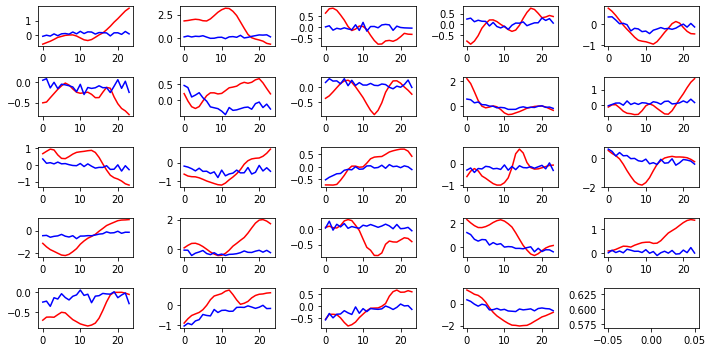

Step: 0, Train Loss: 0.4206593632698059
Step: 20, Train Loss: 0.27967482805252075
Step: 40, Train Loss: 0.377156138420105
Step: 60, Train Loss: 0.44432753324508667
Step: 80, Train Loss: 0.305797278881073
Step: 100, Train Loss: 0.45260676741600037
Step: 120, Train Loss: 0.4556703567504883
Step: 140, Train Loss: 0.2806931436061859
Epoch: 2, Train loss: 0.4035890263736628
acskill_socre:39.29269939266438, rmse_score:17.746189077923844
Epoch: 2, Valid Score: 21.546510314740537


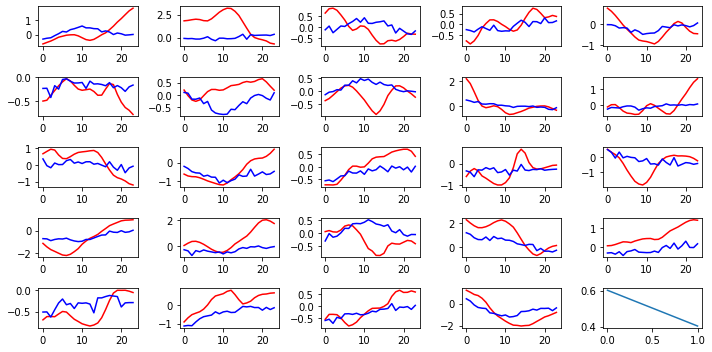

Step: 0, Train Loss: 0.292055606842041
Step: 20, Train Loss: 0.18657344579696655
Step: 40, Train Loss: 0.18544021248817444
Step: 60, Train Loss: 0.20105485618114471
Step: 80, Train Loss: 0.18398511409759521
Step: 100, Train Loss: 0.12071709334850311
Step: 120, Train Loss: 0.2614823579788208
Step: 140, Train Loss: 0.21052831411361694
Epoch: 3, Train loss: 0.21396699780301684
acskill_socre:42.200346901253255, rmse_score:17.671590696696555
Epoch: 3, Valid Score: 24.5287562045567
Model saved successfully


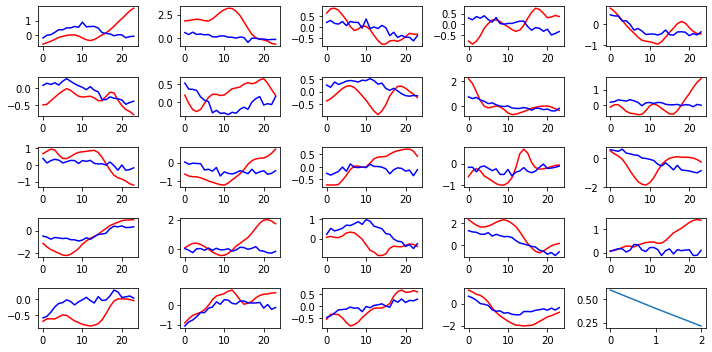

Step: 0, Train Loss: 0.164669468998909
Step: 20, Train Loss: 0.09531857818365097
Step: 40, Train Loss: 0.10145144164562225
Step: 60, Train Loss: 0.1654932200908661
Step: 80, Train Loss: 0.16639114916324615
Step: 100, Train Loss: 0.1431526392698288
Step: 120, Train Loss: 0.12491202354431152
Step: 140, Train Loss: 0.18072447180747986
Epoch: 4, Train loss: 0.13238818601817842
acskill_socre:36.44506543814168, rmse_score:18.043259356148834
Epoch: 4, Valid Score: 18.40180608199285


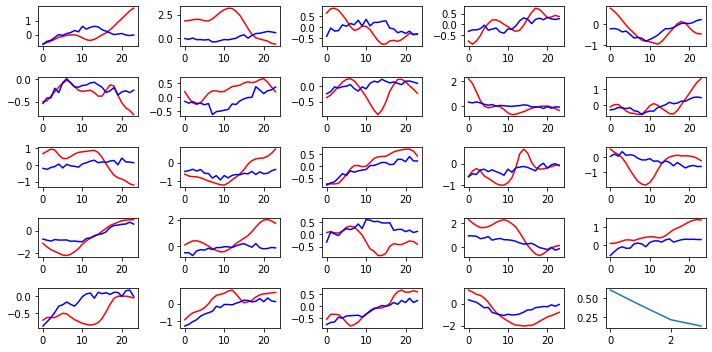

Step: 0, Train Loss: 0.08445814251899719
Step: 20, Train Loss: 0.13805502653121948
Step: 40, Train Loss: 0.07722416520118713
Step: 60, Train Loss: 0.11710835993289948
Step: 80, Train Loss: 0.07662931084632874
Step: 100, Train Loss: 0.10694240033626556
Step: 120, Train Loss: 0.0839809775352478
Step: 140, Train Loss: 0.11787039041519165
Epoch: 5, Train loss: 0.11063289125064377
acskill_socre:37.62301449245112, rmse_score:17.616825911795512
Epoch: 5, Valid Score: 20.006188580655607


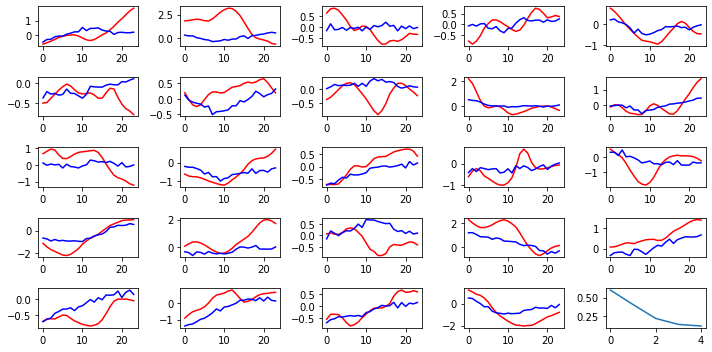

Step: 0, Train Loss: 0.07396218925714493
Step: 20, Train Loss: 0.10265544056892395
Step: 40, Train Loss: 0.09945914149284363
Step: 60, Train Loss: 0.13524453341960907
Step: 80, Train Loss: 0.09824373573064804
Step: 100, Train Loss: 0.07852690666913986
Step: 120, Train Loss: 0.12280334532260895
Step: 140, Train Loss: 0.07453654706478119
Epoch: 6, Train loss: 0.09635312340346872
acskill_socre:36.65697752298365, rmse_score:17.813156720573524
Epoch: 6, Valid Score: 18.84382080241013


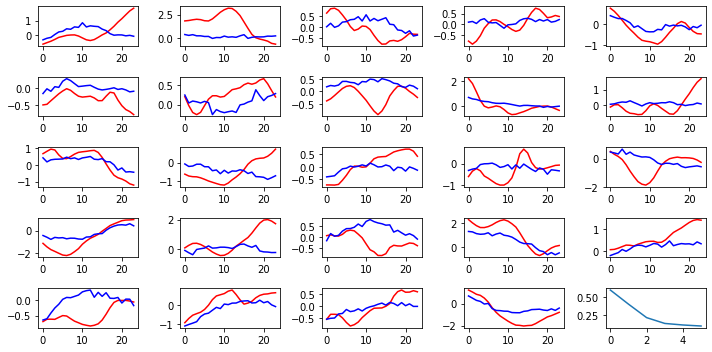

Step: 0, Train Loss: 0.15076857805252075
Step: 20, Train Loss: 0.058089729398489
Step: 40, Train Loss: 0.059170566499233246
Step: 60, Train Loss: 0.07880210876464844
Step: 80, Train Loss: 0.07734902203083038
Step: 100, Train Loss: 0.0660049244761467
Step: 120, Train Loss: 0.05767123028635979
Step: 140, Train Loss: 0.1475108116865158
Epoch: 7, Train loss: 0.08786487674257558
acskill_socre:39.176292217660844, rmse_score:17.82172918686666
Epoch: 7, Valid Score: 21.354563030794186


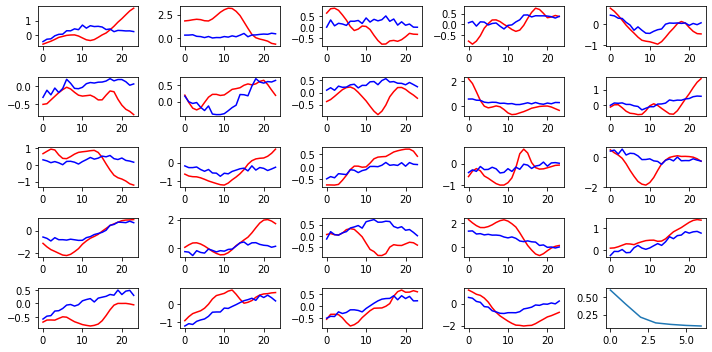

Step: 0, Train Loss: 0.14769577980041504
Step: 20, Train Loss: 0.04416527971625328
Step: 40, Train Loss: 0.055705636739730835
Step: 60, Train Loss: 0.06409823149442673
Step: 80, Train Loss: 0.05648195743560791
Step: 100, Train Loss: 0.06836579740047455
Step: 120, Train Loss: 0.07672861218452454
Step: 140, Train Loss: 0.08102734386920929
Epoch: 8, Train loss: 0.07887827049774729
acskill_socre:40.85114730812804, rmse_score:17.907860021077866
Epoch: 8, Valid Score: 22.943287287050175


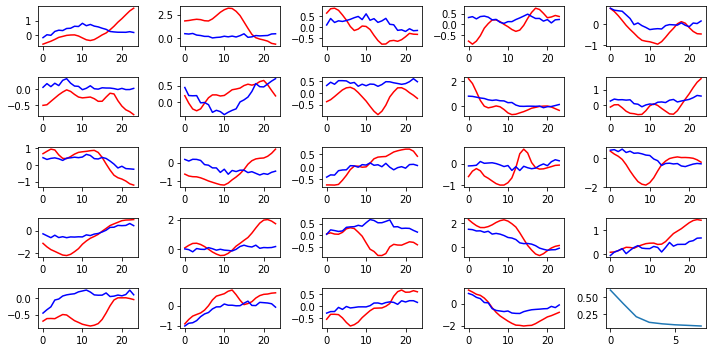

Step: 0, Train Loss: 0.06436023116111755
Step: 20, Train Loss: 0.06759786605834961
Step: 40, Train Loss: 0.06808104366064072
Step: 60, Train Loss: 0.06286362558603287
Step: 80, Train Loss: 0.05795979127287865
Step: 100, Train Loss: 0.08446913957595825
Step: 120, Train Loss: 0.03402324765920639
Step: 140, Train Loss: 0.04469618201255798
Epoch: 9, Train loss: 0.07179603922613867
acskill_socre:42.15791825849038, rmse_score:17.29575978929726
Epoch: 9, Valid Score: 24.862158469193123
Model saved successfully


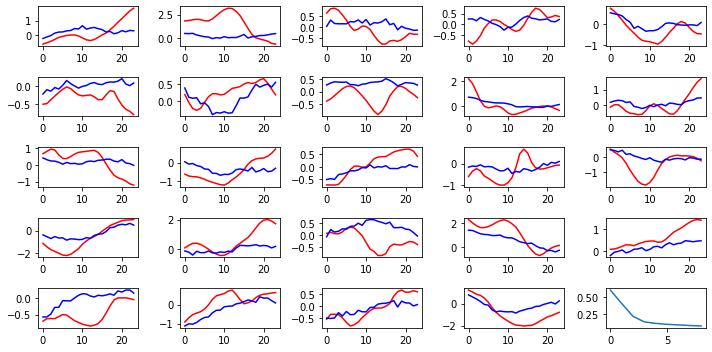

Step: 0, Train Loss: 0.08183760195970535
Step: 20, Train Loss: 0.05603715777397156
Step: 40, Train Loss: 0.058198340237140656
Step: 60, Train Loss: 0.06544553488492966
Step: 80, Train Loss: 0.06039344519376755
Step: 100, Train Loss: 0.043497465550899506
Step: 120, Train Loss: 0.06222086399793625
Step: 140, Train Loss: 0.07727865874767303
Epoch: 10, Train loss: 0.06368820767873412
acskill_socre:42.721228291302424, rmse_score:17.713358200860718
Epoch: 10, Valid Score: 25.007870090441706
Model saved successfully


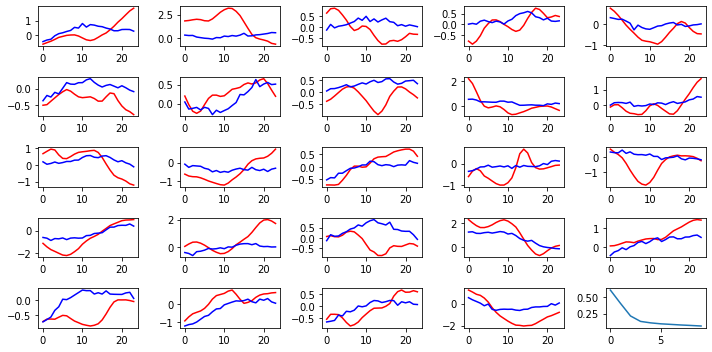

Step: 0, Train Loss: 0.061575375497341156
Step: 20, Train Loss: 0.10408097505569458
Step: 40, Train Loss: 0.038172826170921326
Step: 60, Train Loss: 0.10873937606811523
Step: 80, Train Loss: 0.038075510412454605
Step: 100, Train Loss: 0.05956084653735161
Step: 120, Train Loss: 0.04806724190711975
Step: 140, Train Loss: 0.07381542026996613
Epoch: 11, Train loss: 0.06641244107655658
acskill_socre:41.282102446348716, rmse_score:17.675819380956444
Epoch: 11, Valid Score: 23.606283065392272


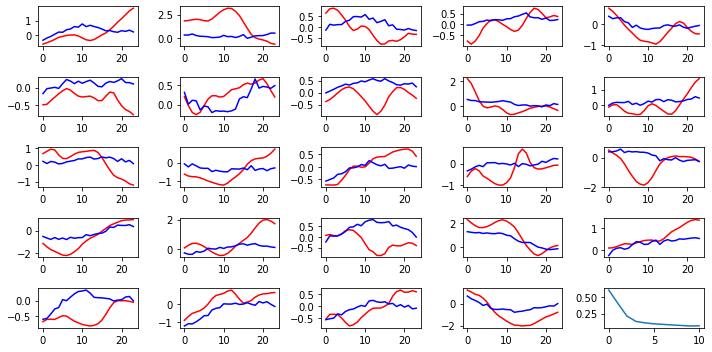

Step: 0, Train Loss: 0.0671529769897461
Step: 20, Train Loss: 0.06813971698284149
Step: 40, Train Loss: 0.07839804887771606
Step: 60, Train Loss: 0.06643243134021759
Step: 80, Train Loss: 0.03632000833749771
Step: 100, Train Loss: 0.03406281769275665
Step: 120, Train Loss: 0.04712032526731491
Step: 140, Train Loss: 0.04061958193778992
Epoch: 12, Train loss: 0.05632255432806957
acskill_socre:40.117053419201746, rmse_score:17.392622419067614
Epoch: 12, Valid Score: 22.724431000134132


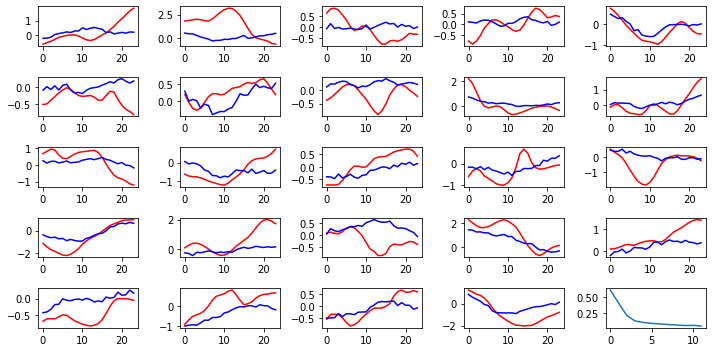

Step: 0, Train Loss: 0.04786234349012375
Step: 20, Train Loss: 0.03931323438882828
Step: 40, Train Loss: 0.05361056327819824
Step: 60, Train Loss: 0.11594676226377487
Step: 80, Train Loss: 0.04609040170907974
Step: 100, Train Loss: 0.0508020743727684
Step: 120, Train Loss: 0.05437582731246948
Step: 140, Train Loss: 0.03619784116744995
Epoch: 13, Train loss: 0.05417709789315986
acskill_socre:41.15610977045861, rmse_score:17.282481392219427
Epoch: 13, Valid Score: 23.873628378239186


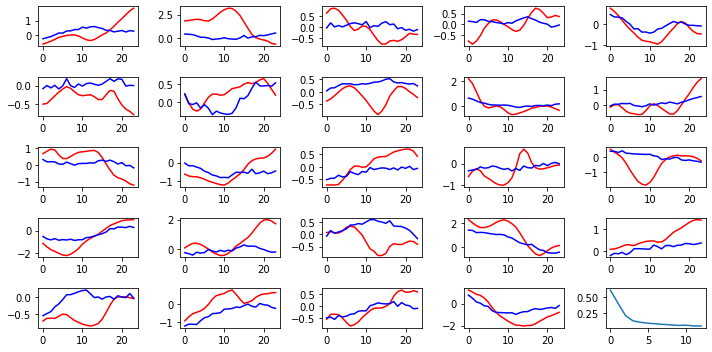

Step: 0, Train Loss: 0.03950991481542587
Step: 20, Train Loss: 0.08789293467998505
Step: 40, Train Loss: 0.04737592488527298
Step: 60, Train Loss: 0.10562227666378021
Step: 80, Train Loss: 0.09084268659353256
Step: 100, Train Loss: 0.061041779816150665
Step: 120, Train Loss: 0.04737105593085289
Step: 140, Train Loss: 0.03485826402902603
Epoch: 14, Train loss: 0.05185507305535921
acskill_socre:40.40926442860386, rmse_score:17.52867351977746
Epoch: 14, Valid Score: 22.880590908826402


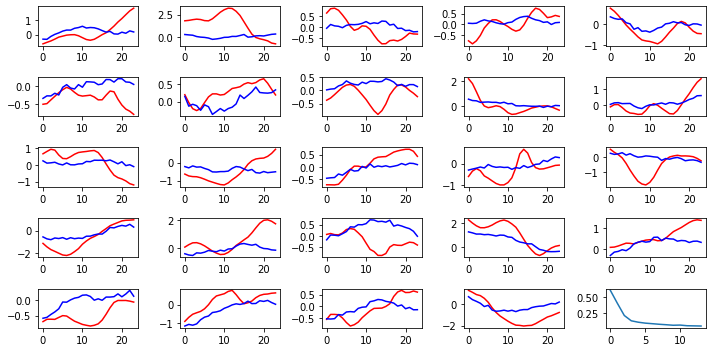

Step: 0, Train Loss: 0.04132125899195671
Step: 20, Train Loss: 0.043919265270233154
Step: 40, Train Loss: 0.03232986852526665
Step: 60, Train Loss: 0.030408062040805817
Step: 80, Train Loss: 0.04761197417974472
Step: 100, Train Loss: 0.04813414812088013
Step: 120, Train Loss: 0.04130285233259201
Step: 140, Train Loss: 0.06141137331724167
Epoch: 15, Train loss: 0.05324885879115314
acskill_socre:44.30034809447875, rmse_score:17.593652240466003
Epoch: 15, Valid Score: 26.706695854012747
Model saved successfully


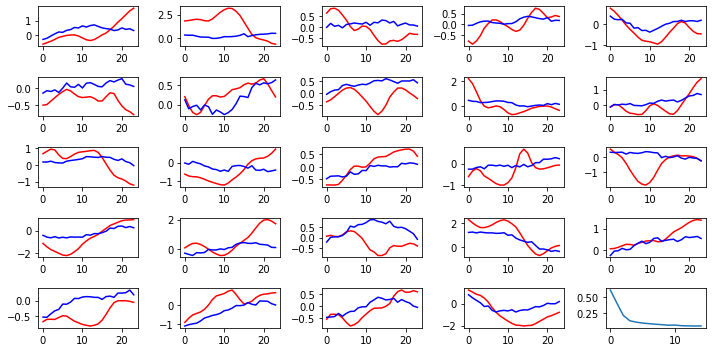

Step: 0, Train Loss: 0.024855321273207664
Step: 20, Train Loss: 0.03797086328268051
Step: 40, Train Loss: 0.022473586723208427
Step: 60, Train Loss: 0.03729843348264694
Step: 80, Train Loss: 0.043483149260282516
Step: 100, Train Loss: 0.028623854741454124
Step: 120, Train Loss: 0.029835065826773643
Step: 140, Train Loss: 0.10181483626365662
Epoch: 16, Train loss: 0.05149124794087972
acskill_socre:42.46578910981039, rmse_score:17.54719840731695
Epoch: 16, Valid Score: 24.918590702493436


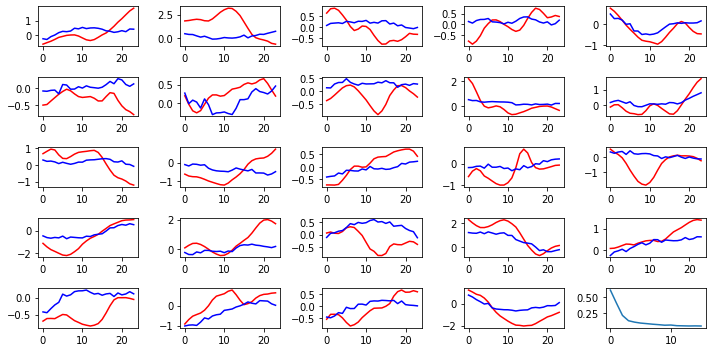

Step: 0, Train Loss: 0.03498993441462517
Step: 20, Train Loss: 0.04302535578608513
Step: 40, Train Loss: 0.043378882110118866
Step: 60, Train Loss: 0.08388170599937439
Step: 80, Train Loss: 0.06828181445598602
Step: 100, Train Loss: 0.06871981918811798
Step: 120, Train Loss: 0.061960797756910324
Step: 140, Train Loss: 0.03316495567560196
Epoch: 17, Train loss: 0.05438878456023848
acskill_socre:45.78733255490481, rmse_score:17.313538392934397
Epoch: 17, Valid Score: 28.47379416197041
Model saved successfully


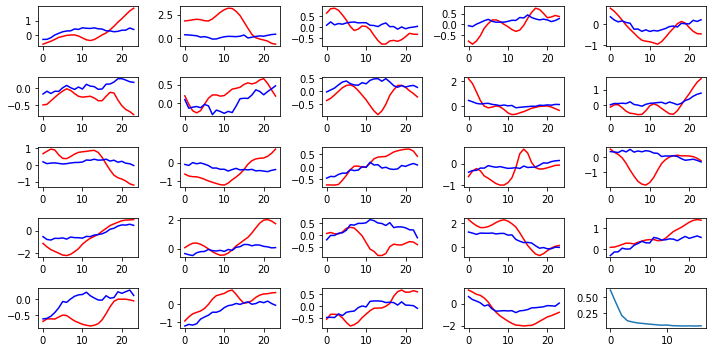

Step: 0, Train Loss: 0.02718268893659115
Step: 20, Train Loss: 0.10212856531143188
Step: 40, Train Loss: 0.054272525012493134
Step: 60, Train Loss: 0.048919614404439926
Step: 80, Train Loss: 0.0486646369099617
Step: 100, Train Loss: 0.07482317090034485
Step: 120, Train Loss: 0.045986972749233246
Step: 140, Train Loss: 0.06472204625606537
Epoch: 18, Train loss: 0.05179190993973404
acskill_socre:42.97674271244018, rmse_score:17.167110836356695
Epoch: 18, Valid Score: 25.809631876083483


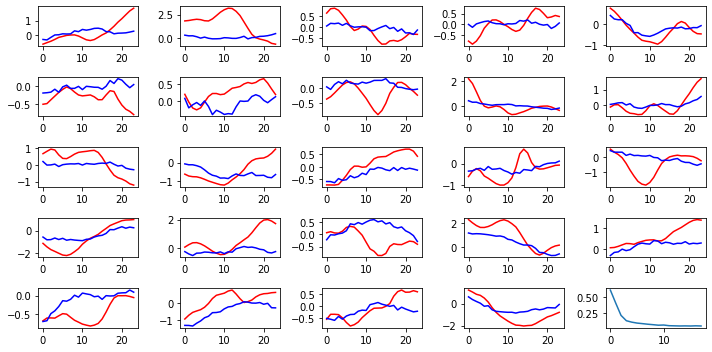

Step: 0, Train Loss: 0.06761747598648071
Step: 20, Train Loss: 0.05649053305387497
Step: 40, Train Loss: 0.05081857740879059
Step: 60, Train Loss: 0.031154010444879532
Step: 80, Train Loss: 0.04961378127336502
Step: 100, Train Loss: 0.028684955090284348
Step: 120, Train Loss: 0.018887314945459366
Step: 140, Train Loss: 0.03681914508342743
Epoch: 19, Train loss: 0.04458547132030414
acskill_socre:43.18722994218133, rmse_score:17.609457155991795
Epoch: 19, Valid Score: 25.577772786189538


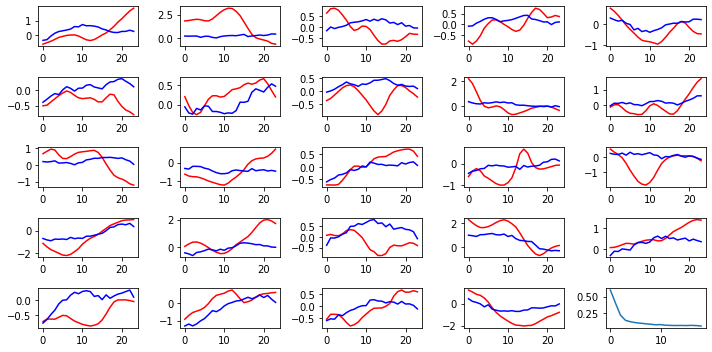

Step: 0, Train Loss: 0.04749858379364014
Step: 20, Train Loss: 0.024657687172293663
Step: 40, Train Loss: 0.032418303191661835
Step: 60, Train Loss: 0.0602034255862236
Step: 80, Train Loss: 0.02227872610092163
Step: 100, Train Loss: 0.031011691316962242
Step: 120, Train Loss: 0.04204143211245537
Step: 140, Train Loss: 0.06691993027925491
Epoch: 20, Train loss: 0.0454838212437121
acskill_socre:44.00029997439107, rmse_score:17.25678533946886
Epoch: 20, Valid Score: 26.74351463492221


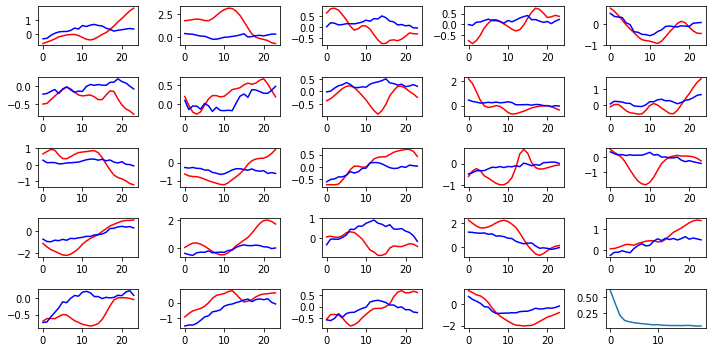

Step: 0, Train Loss: 0.023143187165260315
Step: 20, Train Loss: 0.042813122272491455
Step: 40, Train Loss: 0.035516344010829926
Step: 60, Train Loss: 0.052244167774915695
Step: 80, Train Loss: 0.02586425468325615
Step: 100, Train Loss: 0.07225163280963898
Step: 120, Train Loss: 0.019346613436937332
Step: 140, Train Loss: 0.053567275404930115
Epoch: 21, Train loss: 0.04156487798140307
acskill_socre:41.72667287852246, rmse_score:17.313107461092155
Epoch: 21, Valid Score: 24.413565417430302


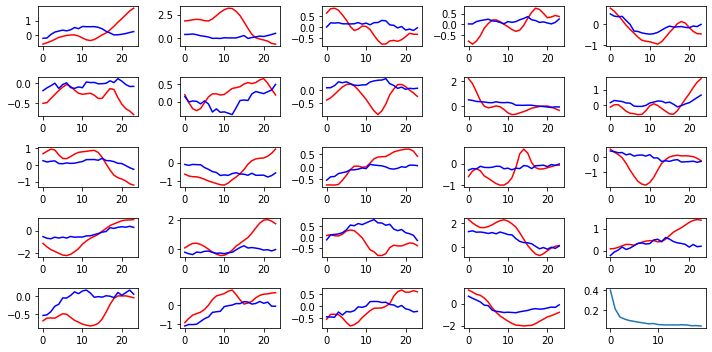

Step: 0, Train Loss: 0.03752710297703743
Step: 20, Train Loss: 0.029237842187285423
Step: 40, Train Loss: 0.04364175722002983
Step: 60, Train Loss: 0.02686977945268154
Step: 80, Train Loss: 0.042853981256484985
Step: 100, Train Loss: 0.06399264186620712
Step: 120, Train Loss: 0.025691621005535126
Step: 140, Train Loss: 0.047340184450149536
Epoch: 22, Train loss: 0.042980002524082066
acskill_socre:46.74573638809906, rmse_score:16.933176084358838
Epoch: 22, Valid Score: 29.812560303740224
Model saved successfully


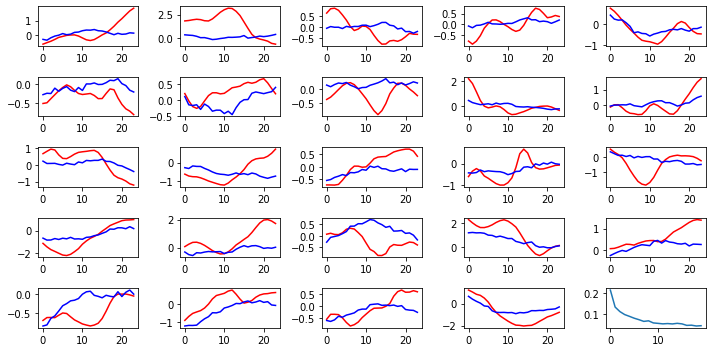

Step: 0, Train Loss: 0.027354072779417038
Step: 20, Train Loss: 0.036311693489551544
Step: 40, Train Loss: 0.06552252173423767
Step: 60, Train Loss: 0.05577138066291809
Step: 80, Train Loss: 0.023281648755073547
Step: 100, Train Loss: 0.030545925721526146
Step: 120, Train Loss: 0.03575955331325531
Step: 140, Train Loss: 0.024232443422079086
Epoch: 23, Train loss: 0.04178744613839563
acskill_socre:46.73006032173693, rmse_score:16.924024523559375
Epoch: 23, Valid Score: 29.806035798177554


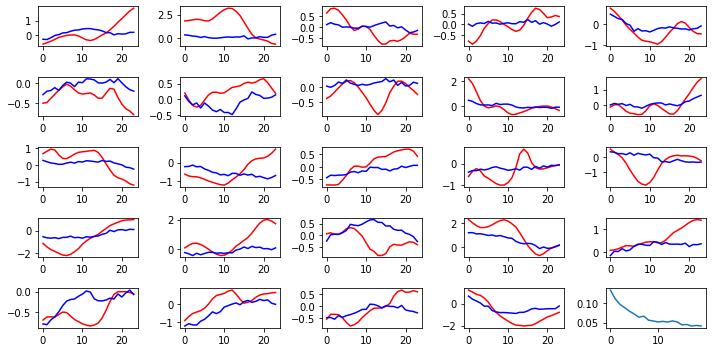

Step: 0, Train Loss: 0.05402132868766785
Step: 20, Train Loss: 0.036132749170064926
Step: 40, Train Loss: 0.020747456699609756
Step: 60, Train Loss: 0.07546359300613403
Step: 80, Train Loss: 0.02724679373204708
Step: 100, Train Loss: 0.02877597138285637
Step: 120, Train Loss: 0.04155977815389633
Step: 140, Train Loss: 0.01713971048593521
Epoch: 24, Train loss: 0.03869148285667987
acskill_socre:48.37059129806096, rmse_score:17.114397723225824
Epoch: 24, Valid Score: 31.256193574835134
Model saved successfully


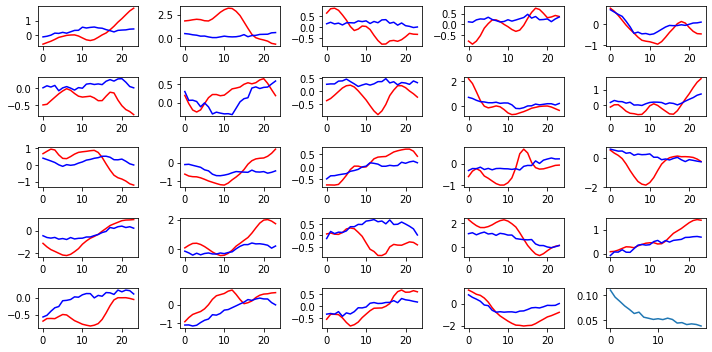

Step: 0, Train Loss: 0.03314700350165367
Step: 20, Train Loss: 0.02048555761575699
Step: 40, Train Loss: 0.035626932978630066
Step: 60, Train Loss: 0.020072046667337418
Step: 80, Train Loss: 0.0176544152200222
Step: 100, Train Loss: 0.029268836602568626
Step: 120, Train Loss: 0.04402492940425873
Step: 140, Train Loss: 0.04367724806070328
Epoch: 25, Train loss: 0.038357710881028205
acskill_socre:46.18721775196316, rmse_score:17.0316055814571
Epoch: 25, Valid Score: 29.15561217050606


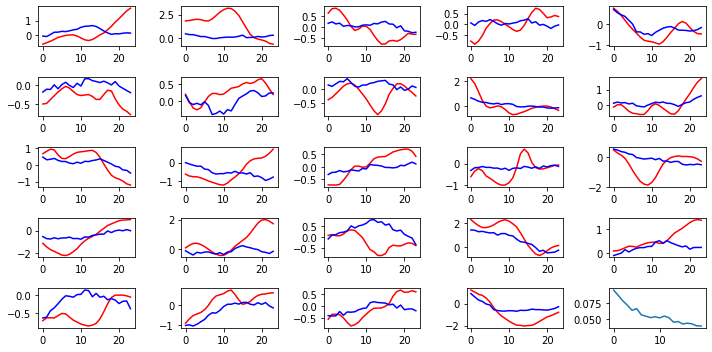

Step: 0, Train Loss: 0.025240343064069748
Step: 20, Train Loss: 0.02616477571427822
Step: 40, Train Loss: 0.03222449868917465
Step: 60, Train Loss: 0.0899968296289444
Step: 80, Train Loss: 0.028783369809389114
Step: 100, Train Loss: 0.020255934447050095
Step: 120, Train Loss: 0.0349162295460701
Step: 140, Train Loss: 0.02408665232360363
Epoch: 26, Train loss: 0.03578775941993401
acskill_socre:46.94318976825119, rmse_score:16.910721584415565
Epoch: 26, Valid Score: 30.032468183835622


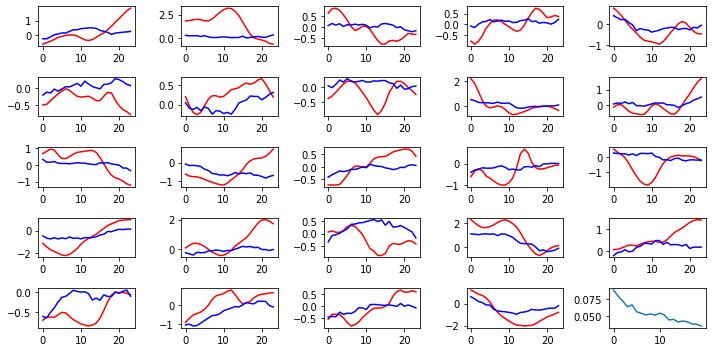

Step: 0, Train Loss: 0.06047918647527695
Step: 20, Train Loss: 0.02593918703496456
Step: 40, Train Loss: 0.03935038670897484
Step: 60, Train Loss: 0.02500024065375328
Step: 80, Train Loss: 0.020466212183237076
Step: 100, Train Loss: 0.04673951491713524
Step: 120, Train Loss: 0.016827944666147232
Step: 140, Train Loss: 0.034318987280130386
Epoch: 27, Train loss: 0.03672217518969136
acskill_socre:51.33922980723762, rmse_score:16.70844436217553
Epoch: 27, Valid Score: 34.63078544506209
Model saved successfully


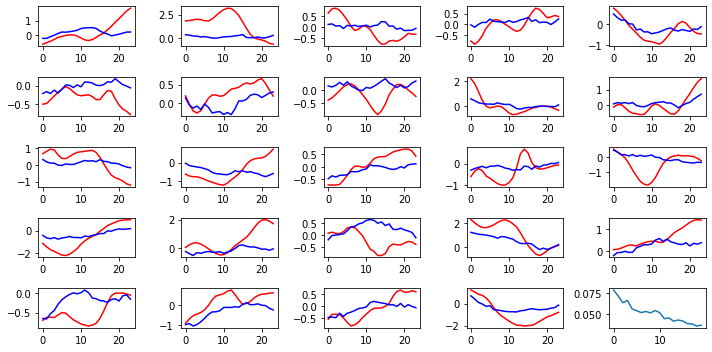

Step: 0, Train Loss: 0.08765535056591034
Step: 20, Train Loss: 0.03846198320388794
Step: 40, Train Loss: 0.08424165099859238
Step: 60, Train Loss: 0.018788877874612808
Step: 80, Train Loss: 0.045383911579847336
Step: 100, Train Loss: 0.06751053035259247
Step: 120, Train Loss: 0.04071785882115364
Step: 140, Train Loss: 0.02845560573041439
Epoch: 28, Train loss: 0.036774512036306085
acskill_socre:48.97227294264229, rmse_score:16.856849005581388
Epoch: 28, Valid Score: 32.1154239370609


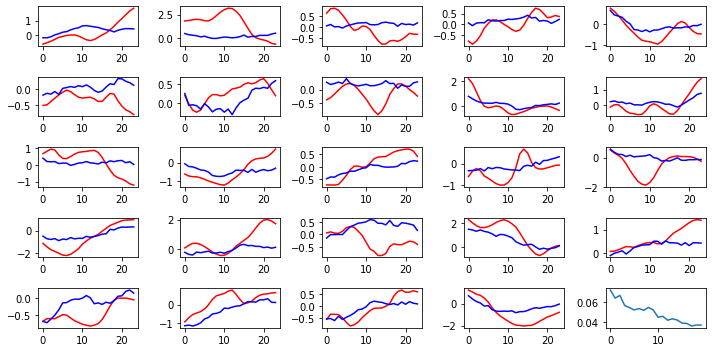

Step: 0, Train Loss: 0.030084645375609398
Step: 20, Train Loss: 0.03582325205206871
Step: 40, Train Loss: 0.03024997189640999
Step: 60, Train Loss: 0.04358852654695511
Step: 80, Train Loss: 0.0630234107375145
Step: 100, Train Loss: 0.03492673113942146
Step: 120, Train Loss: 0.04264242574572563
Step: 140, Train Loss: 0.0465133897960186
Epoch: 29, Train loss: 0.0358274801023257
acskill_socre:44.206078185963676, rmse_score:17.144937963885607
Epoch: 29, Valid Score: 27.06114022207807


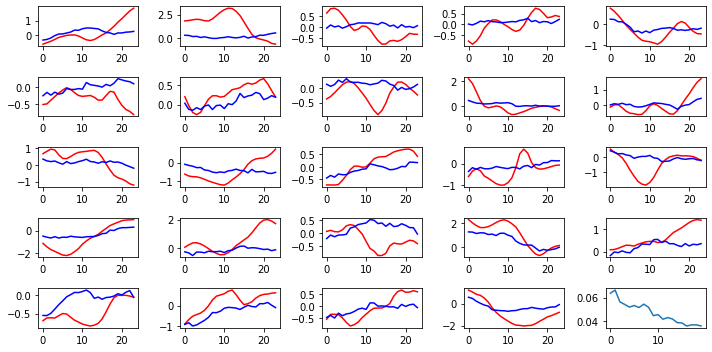

Step: 0, Train Loss: 0.025762444362044334
Step: 20, Train Loss: 0.01785019412636757
Step: 40, Train Loss: 0.033016085624694824
Step: 60, Train Loss: 0.01950659602880478
Step: 80, Train Loss: 0.017047978937625885
Step: 100, Train Loss: 0.026675529778003693
Step: 120, Train Loss: 0.013387131504714489
Step: 140, Train Loss: 0.01666404865682125
Epoch: 30, Train loss: 0.03299212893530442
acskill_socre:42.475932678769226, rmse_score:17.77249063319052
Epoch: 30, Valid Score: 24.703442045578704


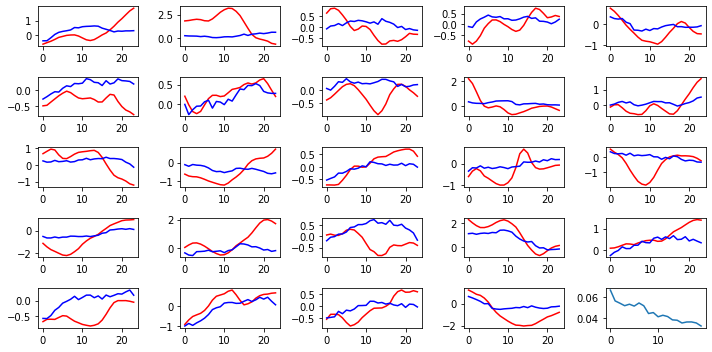

Step: 0, Train Loss: 0.03862118721008301
Step: 20, Train Loss: 0.027679797261953354
Step: 40, Train Loss: 0.02004219964146614
Step: 60, Train Loss: 0.02649833634495735
Step: 80, Train Loss: 0.01891263574361801
Step: 100, Train Loss: 0.032232433557510376
Step: 120, Train Loss: 0.04725387319922447
Step: 140, Train Loss: 0.05782030522823334
Epoch: 31, Train loss: 0.03520899983182265
acskill_socre:48.5316301726002, rmse_score:17.01562603733904
Epoch: 31, Valid Score: 31.516004135261163


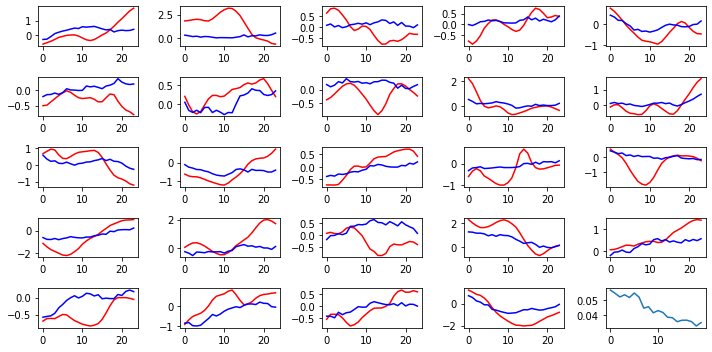

Step: 0, Train Loss: 0.028440143913030624
Step: 20, Train Loss: 0.03711167350411415
Step: 40, Train Loss: 0.031103938817977905
Step: 60, Train Loss: 0.03153301402926445
Step: 80, Train Loss: 0.030708743259310722
Step: 100, Train Loss: 0.019412998110055923
Step: 120, Train Loss: 0.025793088600039482
Step: 140, Train Loss: 0.024892663583159447
Epoch: 32, Train loss: 0.03543380271216297
acskill_socre:50.321874979279784, rmse_score:16.843247385548057
Epoch: 32, Valid Score: 33.47862759373173


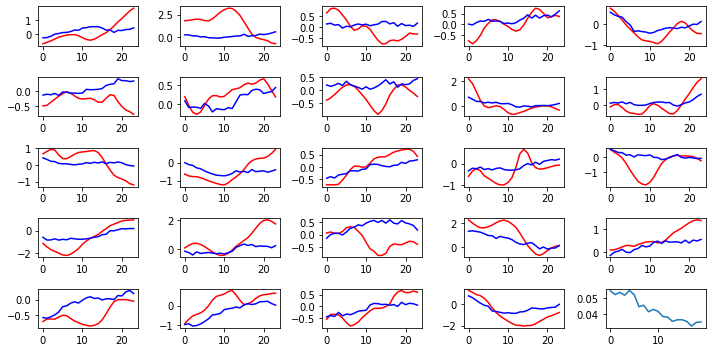

Step: 0, Train Loss: 0.025867503136396408
Step: 20, Train Loss: 0.026851605623960495
Step: 40, Train Loss: 0.021365206688642502
Step: 60, Train Loss: 0.033407293260097504
Step: 80, Train Loss: 0.04499724507331848
Step: 100, Train Loss: 0.028743654489517212
Step: 120, Train Loss: 0.01953025907278061
Step: 140, Train Loss: 0.02660766988992691
Epoch: 33, Train loss: 0.032710021652376194
acskill_socre:49.550214524340596, rmse_score:17.135690631729773
Epoch: 33, Valid Score: 32.41452389261082


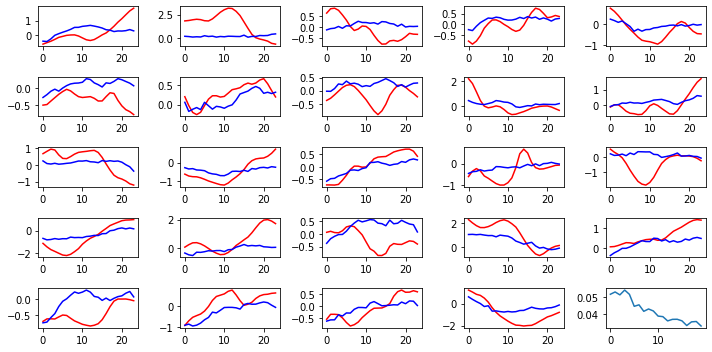

Step: 0, Train Loss: 0.04032760486006737
Step: 20, Train Loss: 0.05490412563085556
Step: 40, Train Loss: 0.022591818124055862
Step: 60, Train Loss: 0.020319581031799316
Step: 80, Train Loss: 0.026199325919151306
Step: 100, Train Loss: 0.03153982013463974
Step: 120, Train Loss: 0.015467154793441296
Step: 140, Train Loss: 0.02226359210908413
Epoch: 34, Train loss: 0.030488813924751463
acskill_socre:49.3688260176765, rmse_score:17.23514405278279
Epoch: 34, Valid Score: 32.13368196489371


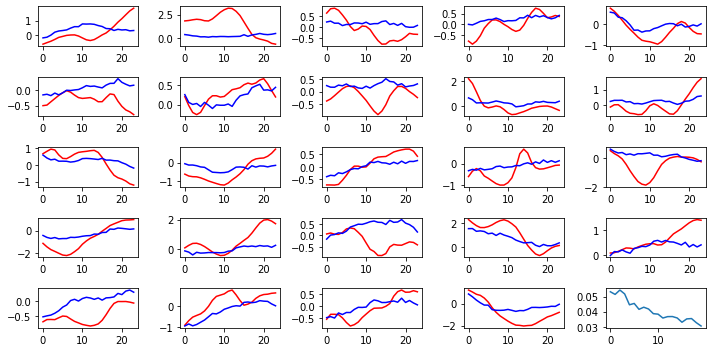

Step: 0, Train Loss: 0.024244222790002823
Step: 20, Train Loss: 0.03001980297267437
Step: 40, Train Loss: 0.020565370097756386
Step: 60, Train Loss: 0.031532883644104004
Step: 80, Train Loss: 0.02704750746488571
Step: 100, Train Loss: 0.04378190264105797
Step: 120, Train Loss: 0.016110045835375786
Step: 140, Train Loss: 0.019422180950641632
Epoch: 35, Train loss: 0.03132872317271058
acskill_socre:47.493419423133425, rmse_score:17.034638170858635
Epoch: 35, Valid Score: 30.45878125227479


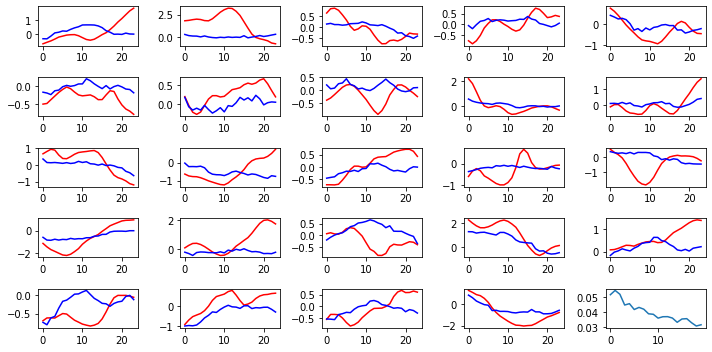

Step: 0, Train Loss: 0.02921197935938835
Step: 20, Train Loss: 0.0312179084867239
Step: 40, Train Loss: 0.027390992268919945
Step: 60, Train Loss: 0.02159193716943264
Step: 80, Train Loss: 0.02608637325465679
Step: 100, Train Loss: 0.019508153200149536
Step: 120, Train Loss: 0.04859606549143791
Step: 140, Train Loss: 0.07184784859418869
Epoch: 36, Train loss: 0.033467447705519425
acskill_socre:52.72512138847925, rmse_score:16.460225311501567
Epoch: 36, Valid Score: 36.264896076977685
Model saved successfully


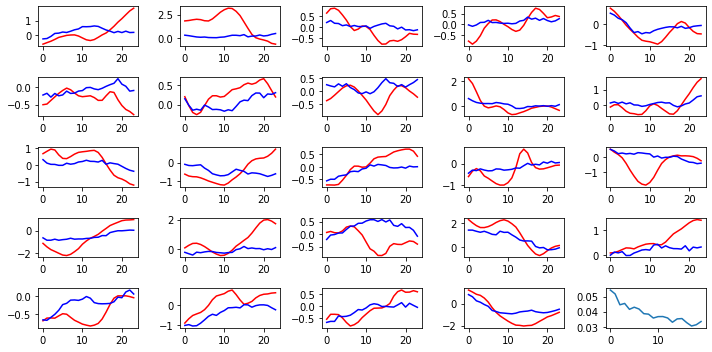

Step: 0, Train Loss: 0.034469544887542725
Step: 20, Train Loss: 0.020230822265148163
Step: 40, Train Loss: 0.029010109603405
Step: 60, Train Loss: 0.02645973488688469
Step: 80, Train Loss: 0.025439530611038208
Step: 100, Train Loss: 0.041311707347631454
Step: 120, Train Loss: 0.031046098098158836
Step: 140, Train Loss: 0.02317705564200878
Epoch: 37, Train loss: 0.03426149698674299
acskill_socre:49.74840305054878, rmse_score:16.779581283374224
Epoch: 37, Valid Score: 32.96882176717456


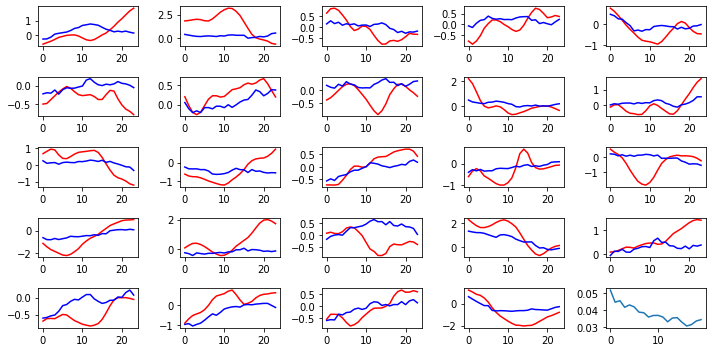

Step: 0, Train Loss: 0.026161182671785355
Step: 20, Train Loss: 0.04176736995577812
Step: 40, Train Loss: 0.027627158910036087
Step: 60, Train Loss: 0.02471977286040783
Step: 80, Train Loss: 0.02167670801281929
Step: 100, Train Loss: 0.030876053497195244
Step: 120, Train Loss: 0.02710787020623684
Step: 140, Train Loss: 0.027551960200071335
Epoch: 38, Train loss: 0.03504408980796861
acskill_socre:49.68213509441803, rmse_score:16.872379517484177
Epoch: 38, Valid Score: 32.80975557693385


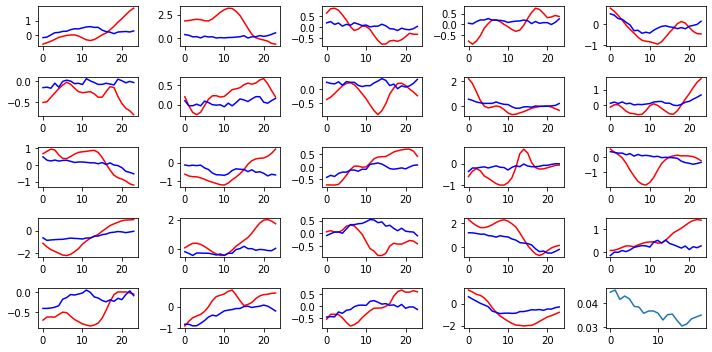

Step: 0, Train Loss: 0.029178213328123093
Step: 20, Train Loss: 0.03082943521440029
Step: 40, Train Loss: 0.03914017230272293
Step: 60, Train Loss: 0.02052878960967064
Step: 80, Train Loss: 0.03053126484155655
Step: 100, Train Loss: 0.0612662099301815
Step: 120, Train Loss: 0.024551596492528915
Step: 140, Train Loss: 0.04779493063688278
Epoch: 39, Train loss: 0.031510613259568714
acskill_socre:48.65319505621412, rmse_score:16.886443357351503
Epoch: 39, Valid Score: 31.76675169886262


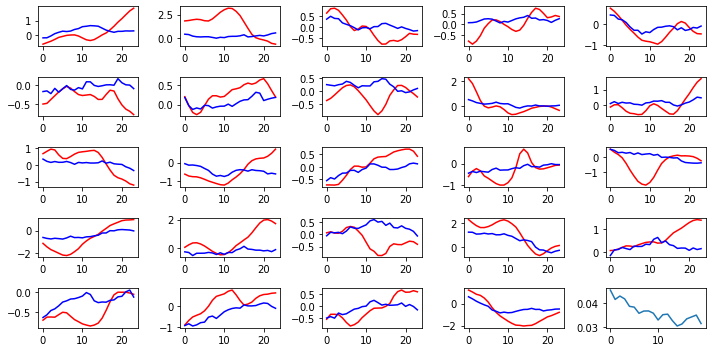

Step: 0, Train Loss: 0.018671654164791107
Step: 20, Train Loss: 0.04947672784328461
Step: 40, Train Loss: 0.023409176617860794
Step: 60, Train Loss: 0.022145532071590424
Step: 80, Train Loss: 0.021692980080842972
Step: 100, Train Loss: 0.021024923771619797
Step: 120, Train Loss: 0.014371035620570183
Step: 140, Train Loss: 0.02021949365735054
Epoch: 40, Train loss: 0.02744736225243397
acskill_socre:46.967861700438, rmse_score:17.294883390487605
Epoch: 40, Valid Score: 29.672978309950395


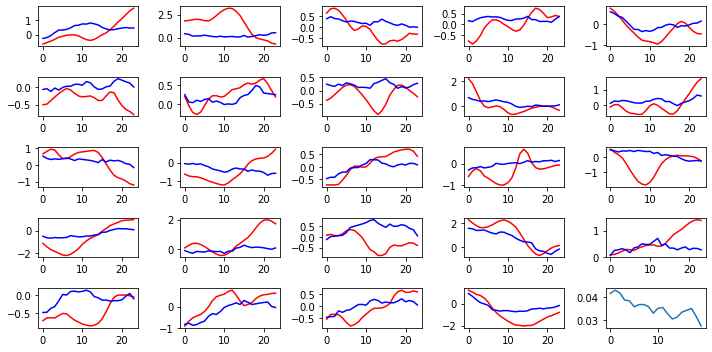

Step: 0, Train Loss: 0.05214362591505051
Step: 20, Train Loss: 0.02292061410844326
Step: 40, Train Loss: 0.037036433815956116
Step: 60, Train Loss: 0.05772867053747177
Step: 80, Train Loss: 0.03106038272380829
Step: 100, Train Loss: 0.022677984088659286
Step: 120, Train Loss: 0.01704196259379387
Step: 140, Train Loss: 0.028756946325302124
Epoch: 41, Train loss: 0.0299675880166091
acskill_socre:46.29504847541439, rmse_score:17.20637370519259
Epoch: 41, Valid Score: 29.0886747702218


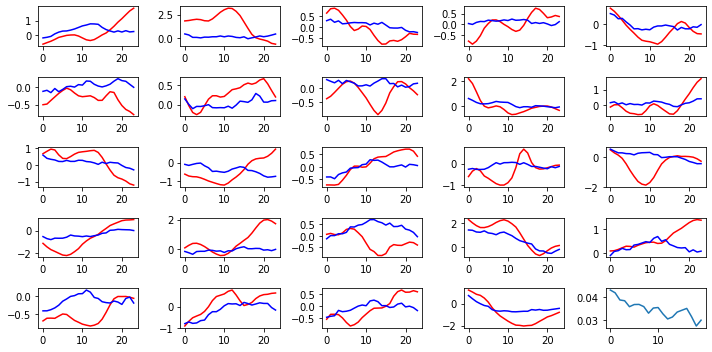

Step: 0, Train Loss: 0.024931922554969788
Step: 20, Train Loss: 0.04147990792989731
Step: 40, Train Loss: 0.02387946844100952
Step: 60, Train Loss: 0.021166345104575157
Step: 80, Train Loss: 0.04027029871940613
Step: 100, Train Loss: 0.017885074019432068
Step: 120, Train Loss: 0.012568706646561623
Step: 140, Train Loss: 0.030759751796722412
Epoch: 42, Train loss: 0.02618000114775577
acskill_socre:49.48192248183745, rmse_score:16.747668437233628
Epoch: 42, Valid Score: 32.73425404460382


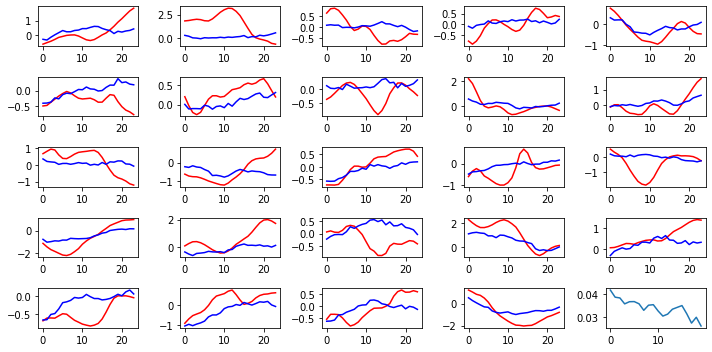

Step: 0, Train Loss: 0.014715972356498241
Step: 20, Train Loss: 0.027682214975357056
Step: 40, Train Loss: 0.01939425617456436
Step: 60, Train Loss: 0.015800554305315018
Step: 80, Train Loss: 0.014820794574916363
Step: 100, Train Loss: 0.014274663291871548
Step: 120, Train Loss: 0.018554674461483955
Step: 140, Train Loss: 0.03069489076733589
Epoch: 43, Train loss: 0.027033913162815722
acskill_socre:47.60903680428718, rmse_score:16.841241510857323
Epoch: 43, Valid Score: 30.767795293429856


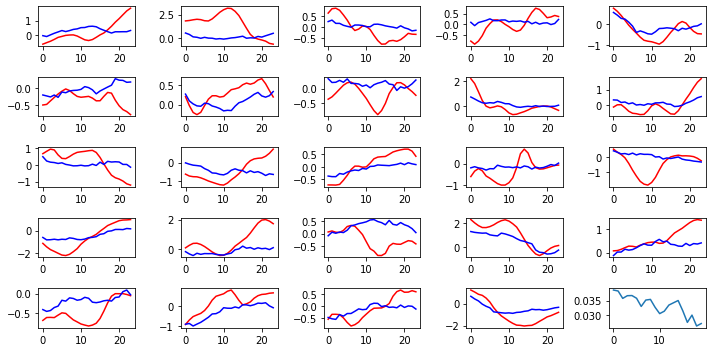

Step: 0, Train Loss: 0.025452222675085068
Step: 20, Train Loss: 0.022948257625102997
Step: 40, Train Loss: 0.04640047252178192
Step: 60, Train Loss: 0.03271067887544632
Step: 80, Train Loss: 0.021213512867689133
Step: 100, Train Loss: 0.015560068190097809
Step: 120, Train Loss: 0.017460357397794724
Step: 140, Train Loss: 0.027988597750663757
Epoch: 44, Train loss: 0.026291925311800402
acskill_socre:48.87595660951468, rmse_score:17.32325803123978
Epoch: 44, Valid Score: 31.5526985782749


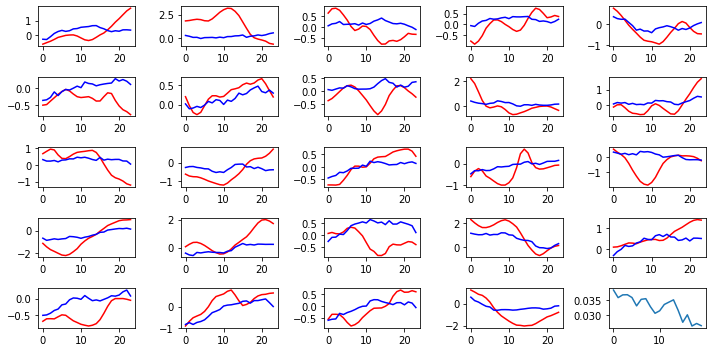

Step: 0, Train Loss: 0.021650191396474838
Step: 20, Train Loss: 0.021717779338359833
Step: 40, Train Loss: 0.034884288907051086
Step: 60, Train Loss: 0.020335108041763306
Step: 80, Train Loss: 0.022233720868825912
Step: 100, Train Loss: 0.017760712653398514
Step: 120, Train Loss: 0.018988104537129402
Step: 140, Train Loss: 0.03549305722117424
Epoch: 45, Train loss: 0.03201039244011519
acskill_socre:44.510968431685654, rmse_score:17.28527121420805
Epoch: 45, Valid Score: 27.225697217477606


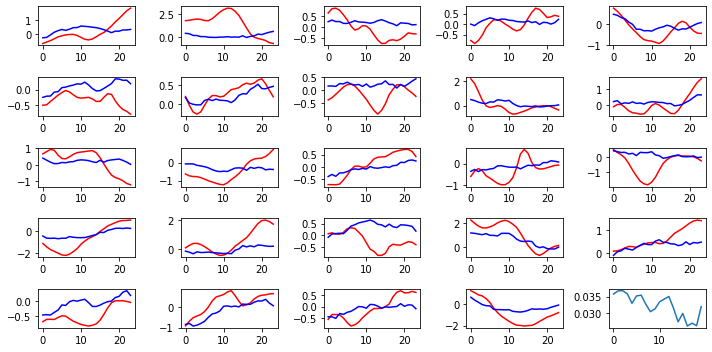

Step: 0, Train Loss: 0.01866353116929531
Step: 20, Train Loss: 0.07648532092571259
Step: 40, Train Loss: 0.027672020718455315
Step: 60, Train Loss: 0.032763853669166565
Step: 80, Train Loss: 0.01810402423143387
Step: 100, Train Loss: 0.018043454736471176
Step: 120, Train Loss: 0.037074603140354156
Step: 140, Train Loss: 0.03744914382696152
Epoch: 46, Train loss: 0.03377869050759988
acskill_socre:45.175033001989746, rmse_score:17.166328333159512
Epoch: 46, Valid Score: 28.008704668830234


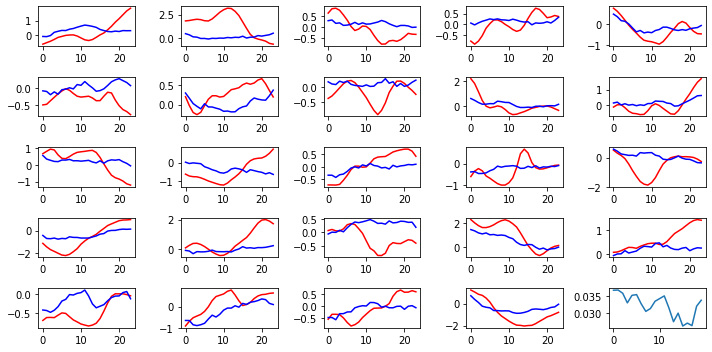

Step: 0, Train Loss: 0.026089807972311974
Step: 20, Train Loss: 0.038112156093120575
Step: 40, Train Loss: 0.022404257208108902
Step: 60, Train Loss: 0.031313542276620865
Step: 80, Train Loss: 0.021514486521482468
Step: 100, Train Loss: 0.01668107882142067
Step: 120, Train Loss: 0.0190604105591774
Step: 140, Train Loss: 0.021855434402823448
Epoch: 47, Train loss: 0.027081337638768802
acskill_socre:43.11650061983744, rmse_score:17.39419070730503
Epoch: 47, Valid Score: 25.72230991253241


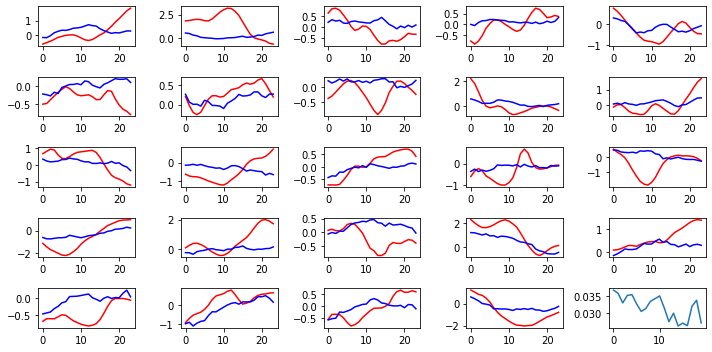

Step: 0, Train Loss: 0.026657944545149803
Step: 20, Train Loss: 0.041124336421489716
Step: 40, Train Loss: 0.01813793182373047
Step: 60, Train Loss: 0.019910652190446854
Step: 80, Train Loss: 0.01917712762951851
Step: 100, Train Loss: 0.014328966848552227
Step: 120, Train Loss: 0.02092183195054531
Step: 140, Train Loss: 0.023155130445957184
Epoch: 48, Train loss: 0.02426462556431248
acskill_socre:43.746445822202816, rmse_score:17.380558738605213
Epoch: 48, Valid Score: 26.365887083597602


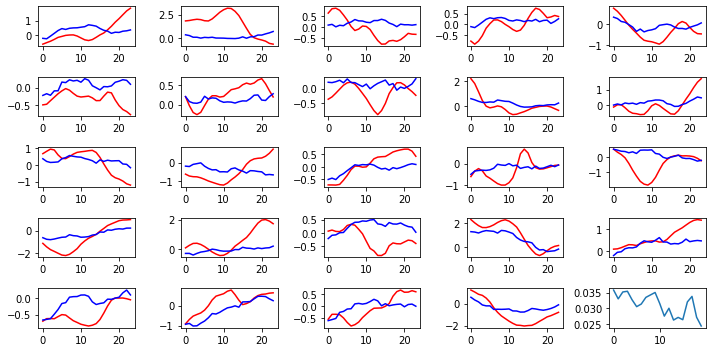

Step: 0, Train Loss: 0.015940941870212555
Step: 20, Train Loss: 0.028270935639739037
Step: 40, Train Loss: 0.018726425245404243
Step: 60, Train Loss: 0.026404326781630516
Step: 80, Train Loss: 0.009818322956562042
Step: 100, Train Loss: 0.02656828984618187
Step: 120, Train Loss: 0.027754342183470726
Step: 140, Train Loss: 0.019315576180815697
Epoch: 49, Train loss: 0.023650573311480367
acskill_socre:48.78904056548183, rmse_score:17.034076534657537
Epoch: 49, Valid Score: 31.75496403082429


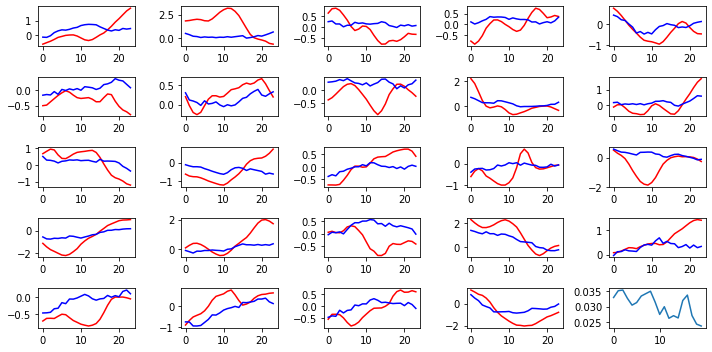

Step: 0, Train Loss: 0.017187099903821945
Step: 20, Train Loss: 0.022800106555223465
Step: 40, Train Loss: 0.011112089268863201
Step: 60, Train Loss: 0.026602445170283318
Step: 80, Train Loss: 0.012347369454801083
Step: 100, Train Loss: 0.03880225867033005
Step: 120, Train Loss: 0.03231652081012726
Step: 140, Train Loss: 0.014246931299567223
Epoch: 50, Train loss: 0.023848391778672196
acskill_socre:46.032042155026346, rmse_score:17.258015488856284
Epoch: 50, Valid Score: 28.774026666170062


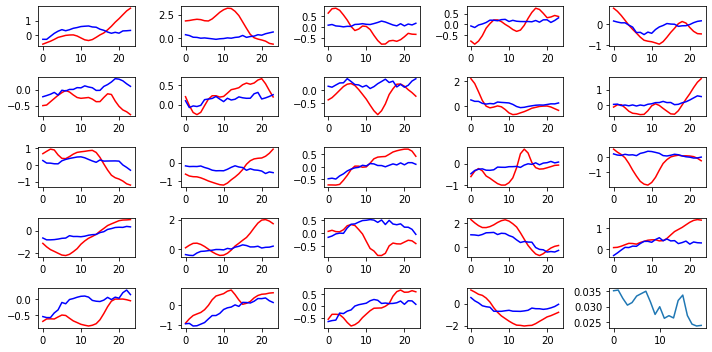

In [30]:
train(num_epochs=50)

In [ ]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

In [15]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [16]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


In [17]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [18]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [19]:
make_zip()